### Step 0: Loading data from kaggle 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/learn-ai-bbc/BBC News Train.csv
/kaggle/input/learn-ai-bbc/BBC News Sample Solution.csv
/kaggle/input/learn-ai-bbc/BBC News Test.csv


In [2]:
# Relevant Imports
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Save data to variable 
train = pd.read_csv('/kaggle/input/learn-ai-bbc/BBC News Train.csv')
test = pd.read_csv('/kaggle/input/learn-ai-bbc/BBC News Test.csv')
sample = pd.read_csv('/kaggle/input/learn-ai-bbc/BBC News Sample Solution.csv')

### Step 1: Exploratory Data Analysis (EDA) & Data Preparation

In [4]:
print(f"Training Data {train.shape}")
print(f'Training Data Attributes: {list(train.columns)}')
print(f'\nTraining Data Types: {train.dtypes}\n')
train.head()

Training Data (1490, 3)
Training Data Attributes: ['ArticleId', 'Text', 'Category']

Training Data Types: ArticleId     int64
Text         object
Category     object
dtype: object



,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [5]:
print(f"Test Data {test.shape}")
print(f'Test Data Attributes: {list(test.columns)}')
test.head()

Test Data (735, 2)
Test Data Attributes: ['ArticleId', 'Text']


,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...


Category
sport            0.232215
business         0.225503
politics         0.183893
entertainment    0.183221
tech             0.175168
Name: proportion, dtype: float64


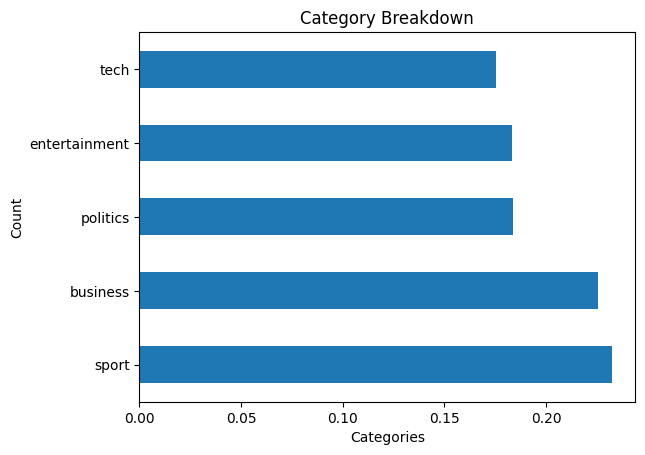

In [6]:
# Get some information about the categories we're working with 
def column_breakdown(column_data): 
    category_breakdown = column_data.value_counts(normalize=True)
    print(category_breakdown)
    category_breakdown.plot(kind='barh')
    plt.xlabel('Categories')
    plt.ylabel('Count')
    plt.title('Category Breakdown')
    plt.show()
    
column_breakdown(train['Category'])

In [7]:
# Check for null values
null_values = train.isnull().sum()
print(f'Null Count:  \n{null_values}')

Null Count:  
ArticleId    0
Text         0
Category     0
dtype: int64


Duplicates found: 50
Category
tech             0.54
entertainment    0.20
politics         0.16
sport            0.08
business         0.02
Name: proportion, dtype: float64


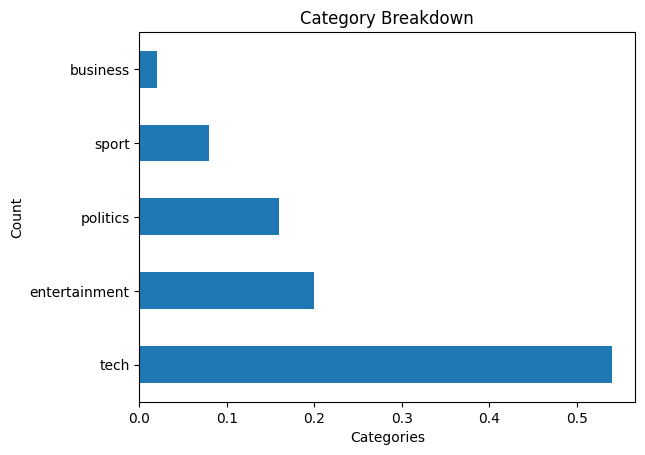

In [8]:
# Check for duplicate rows 
duplicate_rows = train.duplicated(subset=['Category','Text'])
print(f'Duplicates found: {duplicate_rows.sum()}')

# Lets analyze duplicates
duplicates = train[duplicate_rows]
column_breakdown(duplicates['Category'])

In [9]:
train = train.drop_duplicates(subset=['Category', 'Text'], keep='first')
train.shape

(1440, 3)

Category
sport            0.237500
business         0.232639
politics         0.184722
entertainment    0.182639
tech             0.162500
Name: proportion, dtype: float64


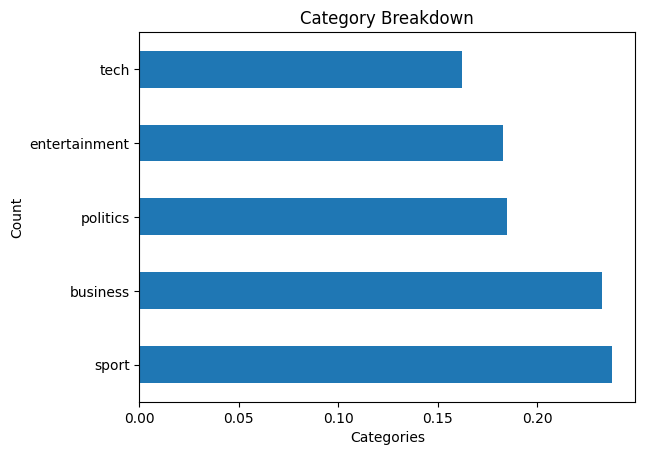

In [10]:
column_breakdown(train['Category'])

### Text Analysis

In [11]:
# Lets look at the Word Counts: 
train['word_count'] = train['Text'].apply(lambda x: len(x.split())) 

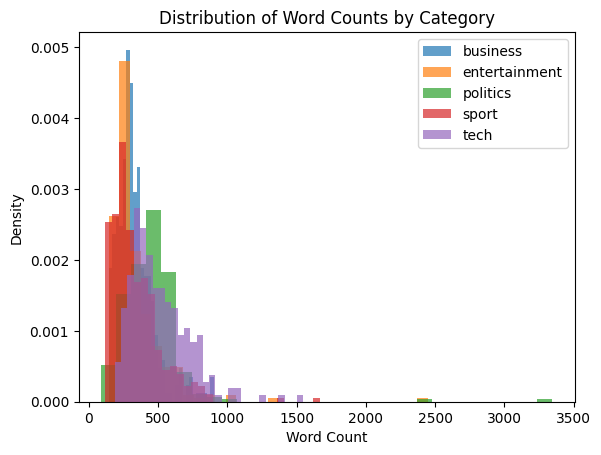

In [12]:
# Plot the distribution of word counts
for category, group in train.groupby('Category'):
    plt.hist(group['word_count'], bins=30, alpha=0.7, label=category, density=True)

plt.legend()
plt.xlabel('Word Count')
plt.ylabel('Density')
plt.title('Distribution of Word Counts by Category')
plt.show()

The above is kind of hard to read...

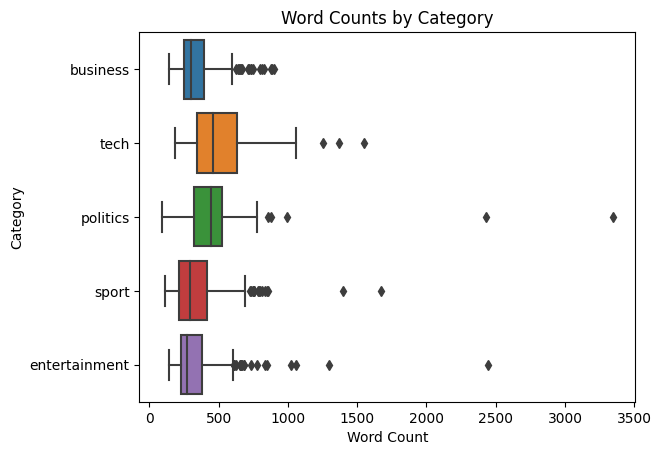

In [13]:
sns.boxplot(x='word_count', y='Category', data=train)
plt.xlabel('Word Count')
plt.ylabel('Category')
plt.title('Word Counts by Category')
plt.show()

In [14]:
grouped = train.groupby('Category')['word_count']
summary_stats = grouped.describe()
print(summary_stats)

               count        mean         std    min     25%    50%     75%  \
Category                                                                     
business       335.0  334.274627  133.713125  145.0  253.00  304.0  391.50   
entertainment  263.0  335.444867  207.134549  144.0  229.00  271.0  380.00   
politics       266.0  451.642857  261.490785   90.0  320.25  445.0  527.75   
sport          342.0  336.877193  185.930006  116.0  211.50  296.5  416.75   
tech           234.0  509.222222  212.922747  188.0  345.25  461.5  633.75   

                  max  
Category               
business        902.0  
entertainment  2448.0  
politics       3345.0  
sport          1671.0  
tech           1549.0  


In [15]:
# Look at what word's we're seeing most common: 
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

# Fit-transform the text data to generate TF-IDF features
tfidf_matrix = vectorizer.fit_transform(train['Text'])

# Sum the TF-IDF values for each word across all documents
sum_scores = tfidf_matrix.sum(axis=0)

# Get the feature names (words) from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Create a DataFrame to store the word frequencies
word_freq_df = pd.DataFrame(sum_scores.T, index=feature_names, columns=['tfidf_score'])

# Sort the DataFrame by the TF-IDF scores in descending order to find the most common words
word_freq_df = word_freq_df.sort_values(by='tfidf_score', ascending=False)

print(f'Words found: {word_freq_df.shape[0]}')
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    pd.set_option('display.max_rows', 500)
    print(word_freq_df)

Words found: 24746
              tfidf_score
the            302.788639
to             142.084594
of             111.166142
in             105.636892
and            105.457836
...                   ...
folds            0.012383
20p              0.012383
manpower         0.012383
hairdressing     0.012383
adair            0.012383

[24746 rows x 1 columns]


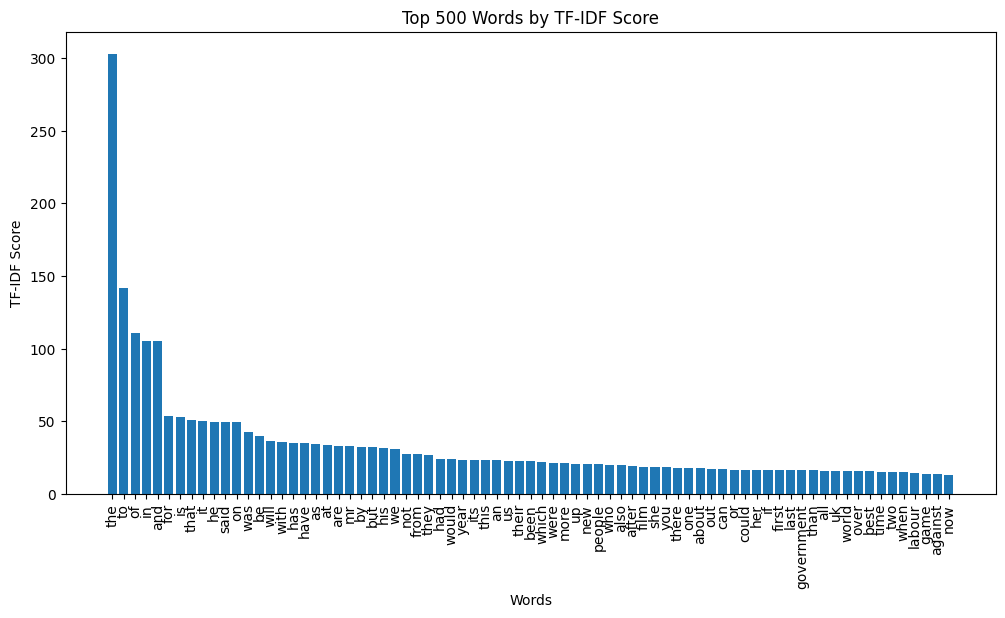

In [16]:
plt.figure(figsize=(12, 6))
plt.bar(word_freq_df.index[:75], word_freq_df['tfidf_score'][:75])
plt.xlabel('Words')
plt.ylabel('TF-IDF Score')
plt.title('Top 500 Words by TF-IDF Score')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()


Here we can see that a lot of the top words are filler words. The good news is that we can remove those with TFIDF!

In [17]:
vectorizer = TfidfVectorizer(stop_words='english')

# Fit-transform the text data to generate TF-IDF features
tfidf_matrix = vectorizer.fit_transform(train['Text'])

# Sum the TF-IDF values for each word across all documents
sum_scores = tfidf_matrix.sum(axis=0)

# Get the feature names (words) from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Create a DataFrame to store the word frequencies
word_freq_df = pd.DataFrame(sum_scores.T, index=feature_names, columns=['tfidf_score'])

# Sort the DataFrame by the TF-IDF scores in descending order to find the most common words
word_freq_df = word_freq_df.sort_values(by='tfidf_score', ascending=False)

print(f'Words found: {word_freq_df.shape[0]}')
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    pd.set_option('display.max_rows', 500)
    print(word_freq_df)

Words found: 24456
          tfidf_score
said        54.972646
mr          36.355483
year        26.176667
people      22.923723
new         22.743713
...               ...
sweat        0.014806
degraded     0.014806
purr         0.014806
gcse         0.014806
elites       0.014806

[24456 rows x 1 columns]


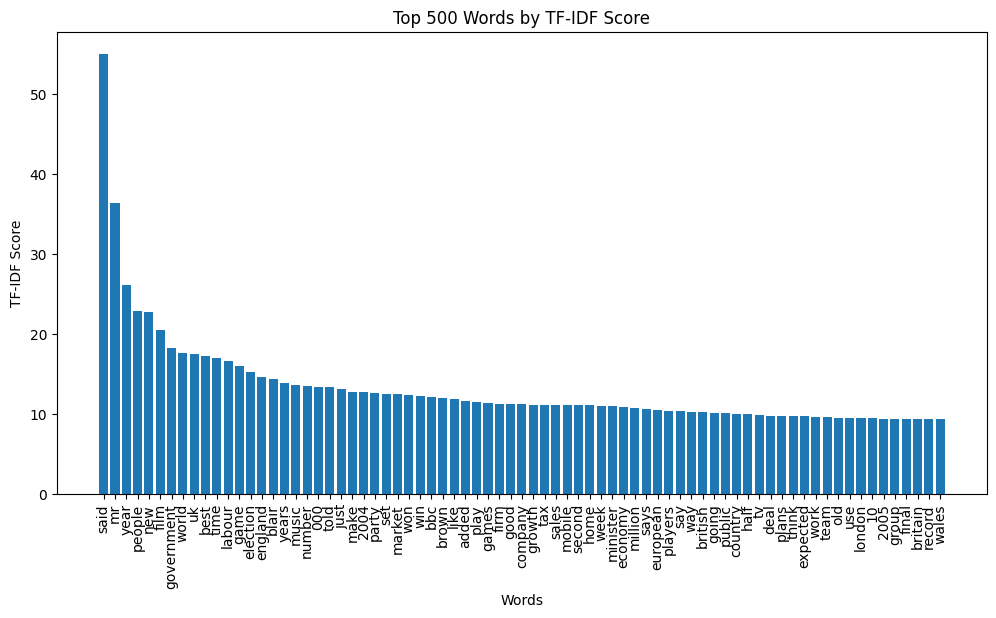

In [18]:
plt.figure(figsize=(12, 6))
plt.bar(word_freq_df.index[:75], word_freq_df['tfidf_score'][:75])
plt.xlabel('Words')
plt.ylabel('TF-IDF Score')
plt.title('Top 500 Words by TF-IDF Score')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()


### Step 2: Unsupervised Model Building

### NMF Model

5
       Topic_1   Topic_2   Topic_3   Topic_4   Topic_5
0     0.001038  0.041245  0.010849  0.002648  0.047263
1     0.000000  0.000000  0.000000  0.000000  0.195315
2     0.014001  0.021956  0.026279  0.001445  0.119681
3     0.000000  0.000000  0.234879  0.000000  0.000000
4     0.006359  0.006194  0.012234  0.007297  0.065131
...        ...       ...       ...       ...       ...
1435  0.022470  0.010807  0.007601  0.036626  0.008827
1436  0.011273  0.002704  0.081032  0.057169  0.000000
1437  0.006815  0.000000  0.004134  0.011701  0.154436
1438  0.000000  0.000000  0.235103  0.001354  0.014731
1439  0.000338  0.000000  0.102573  0.000000  0.000000

[1440 rows x 5 columns]
(4, 2, 1, 0, 3) 0.9083333333333333
{4: 'business', 2: 'tech', 1: 'politics', 0: 'sport', 3: 'entertainment'}


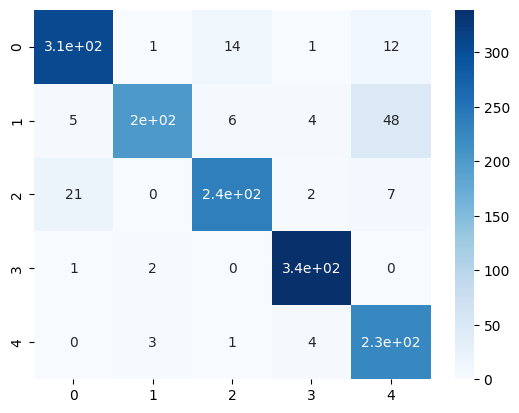

In [19]:
from sklearn.decomposition import NMF
# Now we need to figure out which label corresponds to which category
import itertools
from sklearn.metrics import accuracy_score, confusion_matrix

def label_permute_compare(y,yhat, labels, debug:bool = False):
    """
    y: original labels from training data
    yhat: label predictions from model output
    We need to map the labels given by NMF output to the categories we've got in hand
    We can permute through the results and see which gives highest accuracy.
    Example output: (3, 4, 1, 2, 0), 0.74 
    """
    # get label values + create list of possible permutations
    label_permutations = list(itertools.permutations(range(len(labels))))
    best_label = None
    best_accuracy = 0
    
    for permutation in label_permutations: 
        # Map permutation to real label values
        label_map = {permutation[i]: label for i, label in enumerate(labels)}
        # Map yp to use permuted labels
        yhat_new = [label_map[value] for  value in yhat]
        accuracy = accuracy_score(y, yhat_new)
        # Update if accuracy is better
        if accuracy > best_accuracy: 
            best_accuracy = accuracy
            best_label = permutation 
    return best_label, best_accuracy

def init_model(y,vector_args, model_args):
    vectorizer = TfidfVectorizer()
    # Fit-transform the text data to generate TF-IDF features
    tfidf_matrix = vectorizer.fit_transform(y)
    # Apply NMF for matrix factorization
    labels = y.unique()
    num_topics = len(labels)
    print(num_topics)
    return NMF(n_components=num_topics, **model_args)

def predict_labels(model, n):
    nmf_features = model.fit_transform(tfidf_matrix)
    # Convert the NMF features to a DataFrame for better visualization
    nmf_df = pd.DataFrame(nmf_features, columns=[f"Topic_{i+1}" for i in range(n)])

    # Print the NMF features as a DataFrame
    print(nmf_df)
    # From NMF output we get a probability prediction for each possible category
    # we want to choose the highest
    return np.argmax(nmf_df, axis=1)
    

def NmfModel(y,vector_args = {}, model_args = {}):
    labels = y.unique()
    num_topics = len(labels)
    # build the model 
    model = init_model(y,vector_args, model_args)
    yhat = predict_labels(model, num_topics)
    
    labelorder, acc = label_permute_compare(y, yhat, labels = labels)
    print(labelorder, acc)
    
    # Map values back: 
    label_map = {labelorder[i]: label for i, label in enumerate(labels)}
    print(label_map)
    yp_new = [label_map[value] for  value in yhat]

    # create confusion matrix from results
    conf_matrix = confusion_matrix(y, yp_new)
    sns.heatmap(conf_matrix, annot=True, cmap="Blues")
    
NmfModel(y=train['Category'])

#### Model Tuning

5
       Topic_1   Topic_2   Topic_3   Topic_4   Topic_5
0     0.001038  0.041243  0.010853  0.002649  0.047329
1     0.000000  0.000000  0.000000  0.000000  0.195588
2     0.014002  0.021955  0.026289  0.001445  0.119848
3     0.000000  0.000000  0.234964  0.000000  0.000000
4     0.006360  0.006193  0.012238  0.007298  0.065222
...        ...       ...       ...       ...       ...
1435  0.022472  0.010806  0.007604  0.036631  0.008839
1436  0.011274  0.002704  0.081061  0.057177  0.000000
1437  0.006816  0.000000  0.004135  0.011703  0.154652
1438  0.000000  0.000000  0.235187  0.001355  0.014752
1439  0.000338  0.000000  0.102610  0.000000  0.000000

[1440 rows x 5 columns]
(4, 2, 1, 0, 3) 0.9083333333333333
{4: 'business', 2: 'tech', 1: 'politics', 0: 'sport', 3: 'entertainment'}


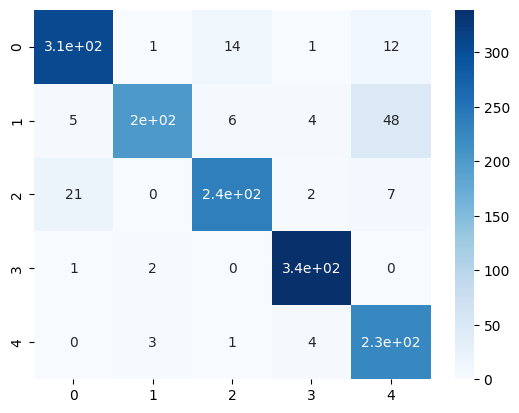

In [20]:
vector_args = {
    'stop_words':'english'
}
NmfModel(y=train['Category'], vector_args = vector_args)

Next we can take a look at model args. Here are some of the main args we can tune 
- init{‘random’, ‘nndsvd’, ‘nndsvda’, ‘nndsvdar’, ‘custom’}, default=None
    None: ‘nndsvda’ if n_components <= min(n_samples, n_features), otherwise random.
    'random': non-negative random matrices, scaled with: sqrt(X.mean() / n_components)
    'nndsvd': Nonnegative Double Singular Value Decomposition (NNDSVD) initialization (better for sparseness)
    'nndsvda': NNDSVD with zeros filled with the average of X (better when sparsity is not desired)
    'nndsvdar' NNDSVD with zeros filled with small random values (generally faster, less accurate alternative to NNDSVDa for when sparsity is not desired)
    'custom': Use custom matrices W and H which must both be provided.
- solver {‘cd’, ‘mu’}, default=’cd’
- beta_loss: float or {‘frobenius’, ‘kullback-leibler’, ‘itakura-saito’}, default=’frobenius’
- l1_ratio
- tol: float, default=1e-4

5
       Topic_1       Topic_2   Topic_3       Topic_4       Topic_5
0     0.004006  3.801080e-02  0.012724  8.147624e-04  3.571666e-02
1     0.000010  8.304194e-07  0.000004  8.873979e-13  1.680378e-01
2     0.018495  2.040357e-02  0.023857  2.984455e-06  1.000361e-01
3     0.000222  2.042893e-09  0.208737  4.788742e-08  1.983500e-15
4     0.010182  7.668991e-04  0.013522  6.241164e-03  5.330724e-02
...        ...           ...       ...           ...           ...
1435  0.026761  8.912925e-03  0.002469  3.426314e-02  7.855715e-03
1436  0.015513  1.668828e-07  0.070691  5.341900e-02  7.173884e-07
1437  0.009565  1.354390e-09  0.006644  1.066812e-02  1.298740e-01
1438  0.000388  2.098991e-10  0.211501  4.732628e-03  3.520210e-03
1439  0.001694  7.080357e-12  0.090864  1.249110e-15  1.153854e-07

[1440 rows x 5 columns]
(4, 2, 1, 0, 3) 0.9048611111111111
{4: 'business', 2: 'tech', 1: 'politics', 0: 'sport', 3: 'entertainment'}


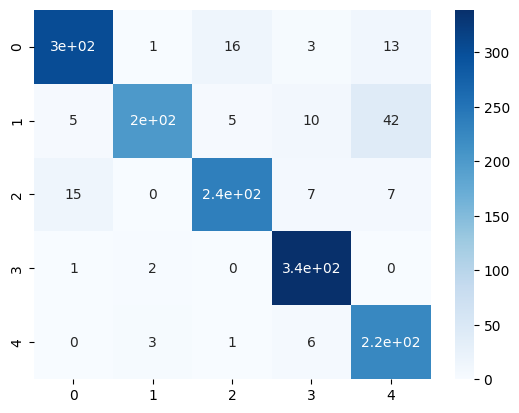

In [21]:
model_args = {
    'solver': 'mu' # CD proved to be best
}
NmfModel(y=train['Category'], model_args = model_args)

#### Final Model Accuracy

### Step 3: Supervised Model Comparison